# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
!pip install -U matplotlib==2.0.2

    100% |████████████████████████████████| 14.6MB 48kB/s  eta 0:00:01
Requirement already up-to-date: cycler>=0.10 in /opt/conda/lib/python3.6/site-packages/cycler-0.10.0-py3.6.egg (from matplotlib==2.0.2)
    100% |████████████████████████████████| 12.2MB 58kB/s  eta 0:00:01
    100% |████████████████████████████████| 215kB 3.3MB/s eta 0:00:01
Requirement already up-to-date: pyparsing!=2.0.0,!=2.0.4,!=2.1.2,!=2.1.6,>=1.5.6 in /opt/conda/lib/python3.6/site-packages (from matplotlib==2.0.2)
    100% |████████████████████████████████| 512kB 1.5MB/s eta 0:00:01
Requirement already up-to-date: six>=1.10 in /opt/conda/lib/python3.6/site-packages (from matplotlib==2.0.2)
  Found existing installation: numpy 1.12.1
    Uninstalling numpy-1.12.1:
      Successfully uninstalled numpy-1.12.1
  Found existing installation: python-dateutil 2.6.1
    Uninstalling python-dateutil-2.6.1:
      Successfully uninstalled python-dateutil-2.6.1
  Found existing installation: pytz 2017.3
    Uninstalling 

In [2]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

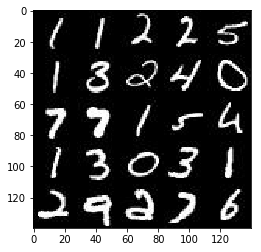

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

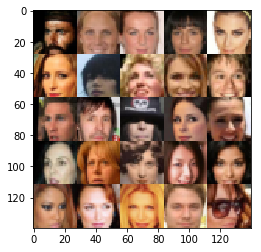

In [4]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [5]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.3.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [6]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    real_input = tf.placeholder(tf.float32, shape=(None, image_width, image_height, image_channels), name='real_input')
    z = tf.placeholder(tf.float32, shape=(None, z_dim), name='z_input')
    learning_rate = tf.placeholder(tf.float32, shape=(), name='learning_rate')
    return real_input, z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [7]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha = 0.2
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 28x28x3
        x1 = tf.layers.conv2d(images, 32, 5, strides=2, padding='same')
        x1 = tf.maximum(x1, alpha*x1)
        # now size is 14*14*32
        x2 = tf.layers.conv2d(x1, 64, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=True)
        x2 = tf.maximum(x2, alpha*x2)
        # now size is 7*7*64
        x3 = tf.layers.conv2d(x2, 128, 4, strides=1, padding='valid')
        x3 = tf.layers.batch_normalization(x3, training=True)
        x3 = tf.maximum(x3, alpha*x3)
        # now size is 4*4*128
        x4 = tf.contrib.layers.flatten(x3)
        logits = tf.layers.dense(x4,1)
        out = tf.nn.sigmoid(logits)
    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

/opt/conda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [8]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    alpha = 0.2
    with tf.variable_scope('generator', reuse=not is_train):
        # First fully connected layer
        x1 = tf.layers.dense(inputs=z, units=4*4*512)
        x1 = tf.reshape(x1, (-1,4,4,512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(x1, alpha*x1)
        # (-1,4,4,512)
        x2 = tf.layers.conv2d_transpose(x1, 256, 4, strides=1, padding='valid')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(x2, alpha*x2)
        # (-1, 7, 7, 256)
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=(2, 2), padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(x3, alpha*x3)
        # (-1, 14, 14, 256)
        logits =tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=(2, 2), padding='same')  
        out = tf.tanh(logits)
        # (-1, 28, 28, 3)
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [9]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model_out = generator(input_z, out_channel_dim, is_train=True)
    _, d_model_logits_real = discriminator(input_real, reuse=False)
    _, d_model_logits_fake = discriminator(g_model_out, reuse=True)
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=tf.ones_like(d_model_logits_real), 
                                                                         logits=d_model_logits_real))
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=tf.zeros_like(d_model_logits_fake),
                                                                         logits=d_model_logits_fake))
    d_loss = d_loss_real + d_loss_fake
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=tf.ones_like(d_model_logits_fake),
                                                                    logits=d_model_logits_fake))
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [10]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    variables = tf.trainable_variables()
    g_vars = [v for v in variables if v.name.startswith('generator')]
    d_vars = [v for v in variables if v.name.startswith('discriminator')]
    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [11]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [12]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    _, image_width, image_height, image_channels = data_shape
    input_real, input_z, l_rate = model_inputs(image_width, image_height, image_channels, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, image_channels)

    d_opt, g_opt = model_opt(d_loss, g_loss, l_rate, beta1)
    
    steps = 0
    losses = []
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1

                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, l_rate: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images, l_rate: learning_rate})
                
                # print current loss
                print_every = 10
                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))
                
                # show artificial images
                show_every = 100
                if steps % show_every == 0:
                    show_generator_output(sess, 12, input_z, image_channels, data_image_mode)
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.0844... Generator Loss: 5.1852
Epoch 1/2... Discriminator Loss: 0.4080... Generator Loss: 2.7370
Epoch 1/2... Discriminator Loss: 1.0657... Generator Loss: 1.2483
Epoch 1/2... Discriminator Loss: 0.4153... Generator Loss: 1.6981
Epoch 1/2... Discriminator Loss: 0.8066... Generator Loss: 1.4285
Epoch 1/2... Discriminator Loss: 0.2852... Generator Loss: 1.9869
Epoch 1/2... Discriminator Loss: 0.2561... Generator Loss: 2.6065
Epoch 1/2... Discriminator Loss: 0.2126... Generator Loss: 2.0825
Epoch 1/2... Discriminator Loss: 0.1364... Generator Loss: 4.4876
Epoch 1/2... Discriminator Loss: 0.7821... Generator Loss: 4.3624


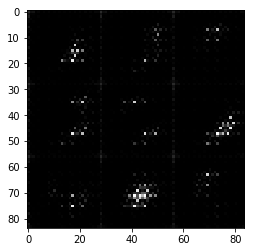

Epoch 1/2... Discriminator Loss: 0.2956... Generator Loss: 2.1608
Epoch 1/2... Discriminator Loss: 0.4607... Generator Loss: 1.3929
Epoch 1/2... Discriminator Loss: 5.8651... Generator Loss: 13.0708
Epoch 1/2... Discriminator Loss: 0.2000... Generator Loss: 3.0677
Epoch 1/2... Discriminator Loss: 0.0879... Generator Loss: 3.0441
Epoch 1/2... Discriminator Loss: 0.8747... Generator Loss: 2.9263
Epoch 1/2... Discriminator Loss: 0.1542... Generator Loss: 4.5325
Epoch 1/2... Discriminator Loss: 0.6791... Generator Loss: 1.3401
Epoch 1/2... Discriminator Loss: 0.2067... Generator Loss: 2.4468
Epoch 1/2... Discriminator Loss: 0.4747... Generator Loss: 1.6695


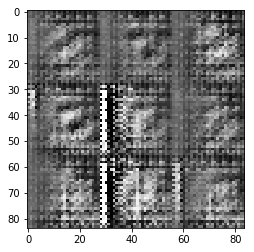

Epoch 1/2... Discriminator Loss: 0.1855... Generator Loss: 3.1705
Epoch 1/2... Discriminator Loss: 0.0816... Generator Loss: 3.7648
Epoch 1/2... Discriminator Loss: 0.1194... Generator Loss: 3.4469
Epoch 1/2... Discriminator Loss: 0.4139... Generator Loss: 2.5385
Epoch 1/2... Discriminator Loss: 0.4296... Generator Loss: 2.6782
Epoch 1/2... Discriminator Loss: 1.1757... Generator Loss: 0.8537
Epoch 1/2... Discriminator Loss: 0.8051... Generator Loss: 0.9828
Epoch 1/2... Discriminator Loss: 0.2973... Generator Loss: 2.1376
Epoch 1/2... Discriminator Loss: 0.1308... Generator Loss: 2.9988
Epoch 1/2... Discriminator Loss: 0.1834... Generator Loss: 2.5723


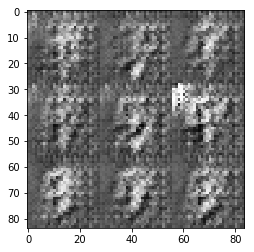

Epoch 1/2... Discriminator Loss: 0.3469... Generator Loss: 1.7866
Epoch 1/2... Discriminator Loss: 0.2556... Generator Loss: 2.2811
Epoch 1/2... Discriminator Loss: 0.1111... Generator Loss: 5.5600
Epoch 1/2... Discriminator Loss: 0.0442... Generator Loss: 5.0347
Epoch 1/2... Discriminator Loss: 2.4344... Generator Loss: 0.2209
Epoch 1/2... Discriminator Loss: 1.0194... Generator Loss: 0.8131
Epoch 1/2... Discriminator Loss: 1.0243... Generator Loss: 1.0674
Epoch 1/2... Discriminator Loss: 0.8010... Generator Loss: 0.8766
Epoch 1/2... Discriminator Loss: 0.4869... Generator Loss: 1.5776
Epoch 1/2... Discriminator Loss: 0.1858... Generator Loss: 2.5300


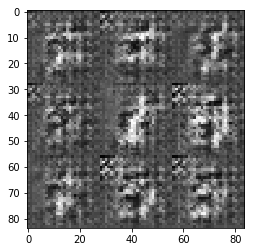

Epoch 1/2... Discriminator Loss: 0.2800... Generator Loss: 2.4692
Epoch 1/2... Discriminator Loss: 1.6830... Generator Loss: 0.3995
Epoch 1/2... Discriminator Loss: 0.3060... Generator Loss: 3.0230
Epoch 1/2... Discriminator Loss: 0.2689... Generator Loss: 2.0434
Epoch 1/2... Discriminator Loss: 0.1701... Generator Loss: 2.5365
Epoch 1/2... Discriminator Loss: 1.9267... Generator Loss: 3.7672
Epoch 1/2... Discriminator Loss: 0.8160... Generator Loss: 0.7854
Epoch 1/2... Discriminator Loss: 0.6213... Generator Loss: 1.0543
Epoch 1/2... Discriminator Loss: 0.2125... Generator Loss: 2.3978
Epoch 1/2... Discriminator Loss: 0.1823... Generator Loss: 2.3043


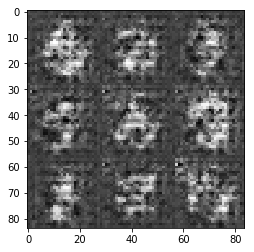

Epoch 1/2... Discriminator Loss: 0.7534... Generator Loss: 2.4534
Epoch 1/2... Discriminator Loss: 0.2733... Generator Loss: 1.9875
Epoch 1/2... Discriminator Loss: 0.4141... Generator Loss: 1.8416
Epoch 1/2... Discriminator Loss: 0.4829... Generator Loss: 3.6939
Epoch 1/2... Discriminator Loss: 0.3253... Generator Loss: 1.7175
Epoch 1/2... Discriminator Loss: 0.1498... Generator Loss: 2.4293
Epoch 1/2... Discriminator Loss: 0.1233... Generator Loss: 2.6807
Epoch 1/2... Discriminator Loss: 0.1220... Generator Loss: 2.7325
Epoch 1/2... Discriminator Loss: 0.0995... Generator Loss: 3.0332
Epoch 1/2... Discriminator Loss: 0.1000... Generator Loss: 3.0623


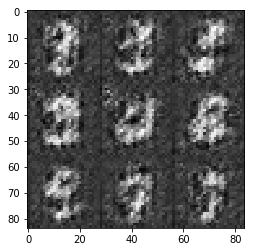

Epoch 1/2... Discriminator Loss: 3.8162... Generator Loss: 3.6389
Epoch 1/2... Discriminator Loss: 0.7463... Generator Loss: 1.3339
Epoch 1/2... Discriminator Loss: 0.9110... Generator Loss: 1.1520
Epoch 1/2... Discriminator Loss: 0.6825... Generator Loss: 1.0398
Epoch 1/2... Discriminator Loss: 0.5792... Generator Loss: 1.2266
Epoch 1/2... Discriminator Loss: 0.4064... Generator Loss: 1.4829
Epoch 1/2... Discriminator Loss: 0.3770... Generator Loss: 1.4859
Epoch 1/2... Discriminator Loss: 2.2881... Generator Loss: 0.1537
Epoch 1/2... Discriminator Loss: 1.0615... Generator Loss: 0.5925
Epoch 1/2... Discriminator Loss: 0.4677... Generator Loss: 1.2795


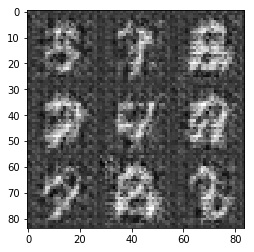

Epoch 1/2... Discriminator Loss: 0.4969... Generator Loss: 1.1792
Epoch 1/2... Discriminator Loss: 0.1771... Generator Loss: 2.7438
Epoch 1/2... Discriminator Loss: 0.2378... Generator Loss: 2.2329
Epoch 1/2... Discriminator Loss: 0.1096... Generator Loss: 2.8994
Epoch 1/2... Discriminator Loss: 0.0709... Generator Loss: 3.7886
Epoch 1/2... Discriminator Loss: 0.1192... Generator Loss: 2.6042
Epoch 1/2... Discriminator Loss: 0.0977... Generator Loss: 2.7905
Epoch 1/2... Discriminator Loss: 0.2363... Generator Loss: 1.9466
Epoch 1/2... Discriminator Loss: 0.0187... Generator Loss: 6.8933
Epoch 1/2... Discriminator Loss: 0.1659... Generator Loss: 2.4115


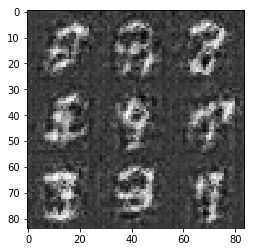

Epoch 1/2... Discriminator Loss: 0.1615... Generator Loss: 2.3158
Epoch 1/2... Discriminator Loss: 0.0724... Generator Loss: 3.3650
Epoch 1/2... Discriminator Loss: 0.2643... Generator Loss: 1.8671
Epoch 1/2... Discriminator Loss: 0.9024... Generator Loss: 1.5722
Epoch 1/2... Discriminator Loss: 0.9302... Generator Loss: 2.6716
Epoch 1/2... Discriminator Loss: 0.4663... Generator Loss: 1.6065
Epoch 1/2... Discriminator Loss: 0.6629... Generator Loss: 1.0082
Epoch 1/2... Discriminator Loss: 0.2661... Generator Loss: 2.5626
Epoch 1/2... Discriminator Loss: 0.3075... Generator Loss: 1.7684
Epoch 1/2... Discriminator Loss: 0.4958... Generator Loss: 1.2061


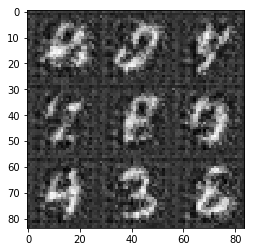

Epoch 1/2... Discriminator Loss: 0.6301... Generator Loss: 1.1460
Epoch 1/2... Discriminator Loss: 0.2409... Generator Loss: 3.0253
Epoch 1/2... Discriminator Loss: 0.0968... Generator Loss: 4.3431
Epoch 2/2... Discriminator Loss: 0.0928... Generator Loss: 4.1896
Epoch 2/2... Discriminator Loss: 0.0302... Generator Loss: 4.7702
Epoch 2/2... Discriminator Loss: 1.0857... Generator Loss: 0.9721
Epoch 2/2... Discriminator Loss: 0.4277... Generator Loss: 1.7269
Epoch 2/2... Discriminator Loss: 0.6027... Generator Loss: 0.9779
Epoch 2/2... Discriminator Loss: 0.3177... Generator Loss: 2.0475
Epoch 2/2... Discriminator Loss: 0.4691... Generator Loss: 1.2339


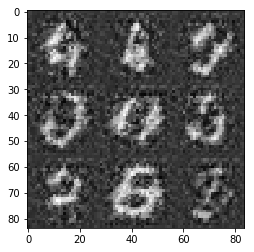

Epoch 2/2... Discriminator Loss: 0.1341... Generator Loss: 2.7452
Epoch 2/2... Discriminator Loss: 0.1432... Generator Loss: 2.5380
Epoch 2/2... Discriminator Loss: 0.1080... Generator Loss: 3.0861
Epoch 2/2... Discriminator Loss: 0.1473... Generator Loss: 2.3912
Epoch 2/2... Discriminator Loss: 0.0499... Generator Loss: 4.1224
Epoch 2/2... Discriminator Loss: 0.1030... Generator Loss: 2.7609
Epoch 2/2... Discriminator Loss: 0.3057... Generator Loss: 3.6304
Epoch 2/2... Discriminator Loss: 0.3306... Generator Loss: 1.7610
Epoch 2/2... Discriminator Loss: 0.2742... Generator Loss: 1.6997
Epoch 2/2... Discriminator Loss: 0.1594... Generator Loss: 2.5403


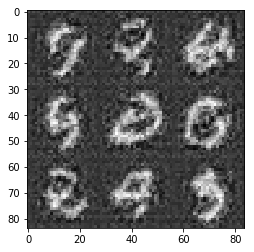

Epoch 2/2... Discriminator Loss: 0.0779... Generator Loss: 3.6075
Epoch 2/2... Discriminator Loss: 0.1189... Generator Loss: 2.7237
Epoch 2/2... Discriminator Loss: 0.0565... Generator Loss: 3.3946
Epoch 2/2... Discriminator Loss: 0.1166... Generator Loss: 6.2929
Epoch 2/2... Discriminator Loss: 0.0647... Generator Loss: 6.1490
Epoch 2/2... Discriminator Loss: 0.0679... Generator Loss: 3.4992
Epoch 2/2... Discriminator Loss: 0.0409... Generator Loss: 4.3521
Epoch 2/2... Discriminator Loss: 0.1123... Generator Loss: 2.7277
Epoch 2/2... Discriminator Loss: 0.0315... Generator Loss: 4.8788
Epoch 2/2... Discriminator Loss: 0.0539... Generator Loss: 3.6878


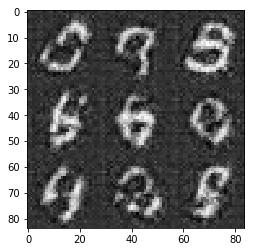

Epoch 2/2... Discriminator Loss: 0.0518... Generator Loss: 3.5472
Epoch 2/2... Discriminator Loss: 0.5087... Generator Loss: 2.2731
Epoch 2/2... Discriminator Loss: 1.7058... Generator Loss: 0.3949
Epoch 2/2... Discriminator Loss: 0.6770... Generator Loss: 1.4481
Epoch 2/2... Discriminator Loss: 0.4689... Generator Loss: 1.4744
Epoch 2/2... Discriminator Loss: 0.4843... Generator Loss: 1.4342
Epoch 2/2... Discriminator Loss: 0.7011... Generator Loss: 0.9298
Epoch 2/2... Discriminator Loss: 0.4569... Generator Loss: 1.2799
Epoch 2/2... Discriminator Loss: 2.0413... Generator Loss: 0.2557
Epoch 2/2... Discriminator Loss: 0.4533... Generator Loss: 2.0368


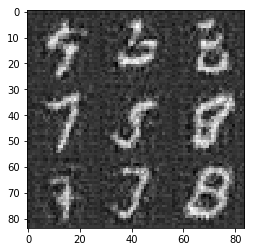

Epoch 2/2... Discriminator Loss: 0.4619... Generator Loss: 1.3013
Epoch 2/2... Discriminator Loss: 0.1829... Generator Loss: 2.2706
Epoch 2/2... Discriminator Loss: 1.2660... Generator Loss: 3.4865
Epoch 2/2... Discriminator Loss: 0.4588... Generator Loss: 1.3906
Epoch 2/2... Discriminator Loss: 0.4505... Generator Loss: 1.4138
Epoch 2/2... Discriminator Loss: 0.4718... Generator Loss: 1.2110
Epoch 2/2... Discriminator Loss: 0.3442... Generator Loss: 1.4892
Epoch 2/2... Discriminator Loss: 0.1123... Generator Loss: 2.9492
Epoch 2/2... Discriminator Loss: 0.1017... Generator Loss: 3.5136
Epoch 2/2... Discriminator Loss: 0.0626... Generator Loss: 4.7411


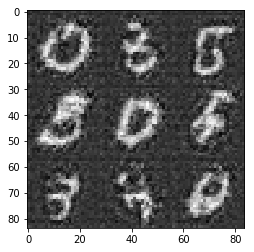

Epoch 2/2... Discriminator Loss: 0.1156... Generator Loss: 2.7291
Epoch 2/2... Discriminator Loss: 0.1385... Generator Loss: 4.8405
Epoch 2/2... Discriminator Loss: 0.0391... Generator Loss: 4.6032
Epoch 2/2... Discriminator Loss: 0.0555... Generator Loss: 3.4917
Epoch 2/2... Discriminator Loss: 0.0479... Generator Loss: 3.8614
Epoch 2/2... Discriminator Loss: 0.0274... Generator Loss: 5.0718
Epoch 2/2... Discriminator Loss: 0.0322... Generator Loss: 4.3600
Epoch 2/2... Discriminator Loss: 0.0214... Generator Loss: 6.0986
Epoch 2/2... Discriminator Loss: 0.0113... Generator Loss: 7.3636
Epoch 2/2... Discriminator Loss: 0.1899... Generator Loss: 2.2608


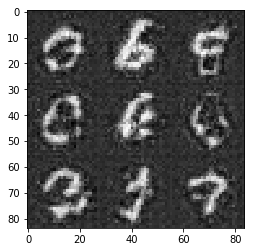

Epoch 2/2... Discriminator Loss: 0.2100... Generator Loss: 2.0894
Epoch 2/2... Discriminator Loss: 0.0377... Generator Loss: 4.3827
Epoch 2/2... Discriminator Loss: 0.5174... Generator Loss: 1.3116
Epoch 2/2... Discriminator Loss: 1.6138... Generator Loss: 0.3521
Epoch 2/2... Discriminator Loss: 0.8825... Generator Loss: 1.9766
Epoch 2/2... Discriminator Loss: 1.0864... Generator Loss: 3.1037
Epoch 2/2... Discriminator Loss: 0.5322... Generator Loss: 1.4041
Epoch 2/2... Discriminator Loss: 0.4764... Generator Loss: 2.0329
Epoch 2/2... Discriminator Loss: 0.5047... Generator Loss: 1.2514
Epoch 2/2... Discriminator Loss: 0.9153... Generator Loss: 5.3948


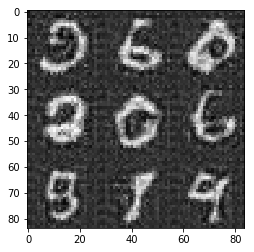

Epoch 2/2... Discriminator Loss: 0.5036... Generator Loss: 1.9232
Epoch 2/2... Discriminator Loss: 0.3167... Generator Loss: 2.0155
Epoch 2/2... Discriminator Loss: 1.1933... Generator Loss: 0.4766
Epoch 2/2... Discriminator Loss: 0.3560... Generator Loss: 1.5161
Epoch 2/2... Discriminator Loss: 0.2326... Generator Loss: 2.1212
Epoch 2/2... Discriminator Loss: 0.2221... Generator Loss: 2.0509
Epoch 2/2... Discriminator Loss: 0.1213... Generator Loss: 2.6149
Epoch 2/2... Discriminator Loss: 0.0576... Generator Loss: 3.7475
Epoch 2/2... Discriminator Loss: 0.1332... Generator Loss: 5.0632
Epoch 2/2... Discriminator Loss: 0.1273... Generator Loss: 2.6048


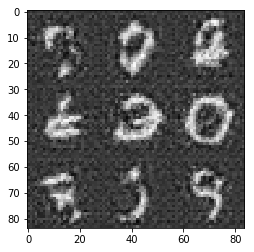

Epoch 2/2... Discriminator Loss: 0.0864... Generator Loss: 2.9965
Epoch 2/2... Discriminator Loss: 0.2659... Generator Loss: 1.7860
Epoch 2/2... Discriminator Loss: 0.1131... Generator Loss: 2.5399
Epoch 2/2... Discriminator Loss: 0.0687... Generator Loss: 3.8122
Epoch 2/2... Discriminator Loss: 0.0610... Generator Loss: 3.5036
Epoch 2/2... Discriminator Loss: 0.0664... Generator Loss: 3.3048
Epoch 2/2... Discriminator Loss: 0.2550... Generator Loss: 1.8434
Epoch 2/2... Discriminator Loss: 0.0623... Generator Loss: 3.6220
Epoch 2/2... Discriminator Loss: 0.0622... Generator Loss: 3.6684
Epoch 2/2... Discriminator Loss: 0.6190... Generator Loss: 2.5299


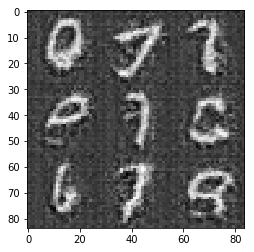

Epoch 2/2... Discriminator Loss: 0.5533... Generator Loss: 1.4899
Epoch 2/2... Discriminator Loss: 0.6383... Generator Loss: 1.1507
Epoch 2/2... Discriminator Loss: 0.5445... Generator Loss: 1.1491
Epoch 2/2... Discriminator Loss: 0.4063... Generator Loss: 2.5456
Epoch 2/2... Discriminator Loss: 0.4741... Generator Loss: 1.2450
Epoch 2/2... Discriminator Loss: 0.1973... Generator Loss: 2.2312
Epoch 2/2... Discriminator Loss: 0.2243... Generator Loss: 2.0305


In [13]:
batch_size = 64
z_dim = 100
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 5.6862... Generator Loss: 0.0041
Epoch 1/1... Discriminator Loss: 0.4690... Generator Loss: 1.1163
Epoch 1/1... Discriminator Loss: 0.2199... Generator Loss: 1.8980
Epoch 1/1... Discriminator Loss: 0.1515... Generator Loss: 4.4817
Epoch 1/1... Discriminator Loss: 0.6930... Generator Loss: 1.3876
Epoch 1/1... Discriminator Loss: 0.1958... Generator Loss: 2.8880
Epoch 1/1... Discriminator Loss: 0.1104... Generator Loss: 10.1938
Epoch 1/1... Discriminator Loss: 0.0887... Generator Loss: 3.4350
Epoch 1/1... Discriminator Loss: 0.0513... Generator Loss: 12.6162
Epoch 1/1... Discriminator Loss: 0.0717... Generator Loss: 4.2079


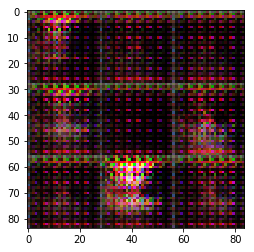

Epoch 1/1... Discriminator Loss: 0.0514... Generator Loss: 3.6756
Epoch 1/1... Discriminator Loss: 0.0754... Generator Loss: 3.0895
Epoch 1/1... Discriminator Loss: 0.0266... Generator Loss: 4.9939
Epoch 1/1... Discriminator Loss: 0.0885... Generator Loss: 2.8874
Epoch 1/1... Discriminator Loss: 0.1125... Generator Loss: 4.1306
Epoch 1/1... Discriminator Loss: 0.1408... Generator Loss: 2.7729
Epoch 1/1... Discriminator Loss: 0.1180... Generator Loss: 3.6767
Epoch 1/1... Discriminator Loss: 1.3081... Generator Loss: 4.5606
Epoch 1/1... Discriminator Loss: 0.3994... Generator Loss: 1.1809
Epoch 1/1... Discriminator Loss: 0.3270... Generator Loss: 1.7779


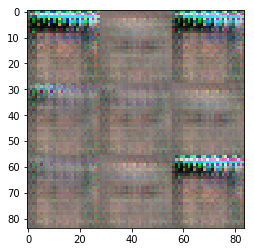

Epoch 1/1... Discriminator Loss: 0.2301... Generator Loss: 2.0852
Epoch 1/1... Discriminator Loss: 4.6171... Generator Loss: 8.6485
Epoch 1/1... Discriminator Loss: 0.1568... Generator Loss: 2.9296
Epoch 1/1... Discriminator Loss: 0.1262... Generator Loss: 2.9101
Epoch 1/1... Discriminator Loss: 0.2274... Generator Loss: 2.4755
Epoch 1/1... Discriminator Loss: 0.2549... Generator Loss: 2.0932
Epoch 1/1... Discriminator Loss: 0.0584... Generator Loss: 4.5370
Epoch 1/1... Discriminator Loss: 0.3460... Generator Loss: 2.3690
Epoch 1/1... Discriminator Loss: 1.1187... Generator Loss: 0.4537
Epoch 1/1... Discriminator Loss: 0.2656... Generator Loss: 2.2611


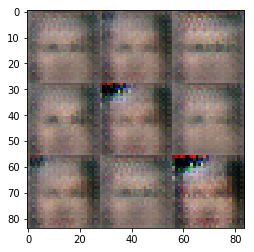

Epoch 1/1... Discriminator Loss: 4.0362... Generator Loss: 6.0915
Epoch 1/1... Discriminator Loss: 0.2428... Generator Loss: 2.0411
Epoch 1/1... Discriminator Loss: 0.2113... Generator Loss: 1.9139
Epoch 1/1... Discriminator Loss: 0.0818... Generator Loss: 3.2696
Epoch 1/1... Discriminator Loss: 0.0694... Generator Loss: 3.2126
Epoch 1/1... Discriminator Loss: 0.0629... Generator Loss: 5.6342
Epoch 1/1... Discriminator Loss: 0.5165... Generator Loss: 2.9995
Epoch 1/1... Discriminator Loss: 0.3234... Generator Loss: 4.3714
Epoch 1/1... Discriminator Loss: 3.7398... Generator Loss: 9.5896
Epoch 1/1... Discriminator Loss: 1.1284... Generator Loss: 0.6832


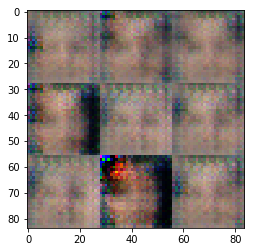

Epoch 1/1... Discriminator Loss: 1.3117... Generator Loss: 2.3118
Epoch 1/1... Discriminator Loss: 0.2641... Generator Loss: 1.8580
Epoch 1/1... Discriminator Loss: 0.1335... Generator Loss: 3.2553
Epoch 1/1... Discriminator Loss: 0.1914... Generator Loss: 2.6858
Epoch 1/1... Discriminator Loss: 0.2436... Generator Loss: 2.6210
Epoch 1/1... Discriminator Loss: 0.0455... Generator Loss: 4.9706
Epoch 1/1... Discriminator Loss: 0.2982... Generator Loss: 1.8482
Epoch 1/1... Discriminator Loss: 1.1419... Generator Loss: 2.9999
Epoch 1/1... Discriminator Loss: 0.0823... Generator Loss: 5.5075
Epoch 1/1... Discriminator Loss: 0.1218... Generator Loss: 3.2507


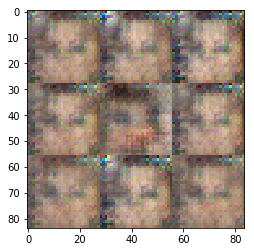

Epoch 1/1... Discriminator Loss: 0.3404... Generator Loss: 2.4293
Epoch 1/1... Discriminator Loss: 5.7868... Generator Loss: 7.4410
Epoch 1/1... Discriminator Loss: 0.6874... Generator Loss: 1.2346
Epoch 1/1... Discriminator Loss: 1.0462... Generator Loss: 5.2371
Epoch 1/1... Discriminator Loss: 0.2054... Generator Loss: 3.0944
Epoch 1/1... Discriminator Loss: 0.3561... Generator Loss: 3.8791
Epoch 1/1... Discriminator Loss: 0.2605... Generator Loss: 2.0908
Epoch 1/1... Discriminator Loss: 0.4517... Generator Loss: 3.2994
Epoch 1/1... Discriminator Loss: 4.1007... Generator Loss: 0.5898
Epoch 1/1... Discriminator Loss: 1.4976... Generator Loss: 0.5756


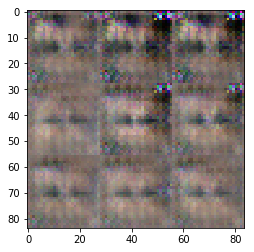

Epoch 1/1... Discriminator Loss: 0.5463... Generator Loss: 1.4102
Epoch 1/1... Discriminator Loss: 1.0512... Generator Loss: 1.0676
Epoch 1/1... Discriminator Loss: 1.1661... Generator Loss: 0.8282
Epoch 1/1... Discriminator Loss: 1.4349... Generator Loss: 0.6702
Epoch 1/1... Discriminator Loss: 1.1453... Generator Loss: 0.8690
Epoch 1/1... Discriminator Loss: 0.9984... Generator Loss: 1.0324
Epoch 1/1... Discriminator Loss: 1.1306... Generator Loss: 1.5399
Epoch 1/1... Discriminator Loss: 1.0996... Generator Loss: 1.0573
Epoch 1/1... Discriminator Loss: 0.8069... Generator Loss: 1.5035
Epoch 1/1... Discriminator Loss: 0.9774... Generator Loss: 0.8322


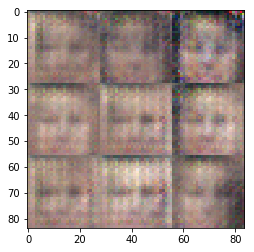

Epoch 1/1... Discriminator Loss: 0.9975... Generator Loss: 1.0380
Epoch 1/1... Discriminator Loss: 1.0490... Generator Loss: 1.1355
Epoch 1/1... Discriminator Loss: 0.8420... Generator Loss: 1.2819
Epoch 1/1... Discriminator Loss: 0.5924... Generator Loss: 1.9548
Epoch 1/1... Discriminator Loss: 0.7780... Generator Loss: 1.2504
Epoch 1/1... Discriminator Loss: 1.6572... Generator Loss: 2.8053
Epoch 1/1... Discriminator Loss: 0.6350... Generator Loss: 1.1171
Epoch 1/1... Discriminator Loss: 1.4218... Generator Loss: 0.3815
Epoch 1/1... Discriminator Loss: 1.4603... Generator Loss: 0.4493
Epoch 1/1... Discriminator Loss: 1.2990... Generator Loss: 1.0019


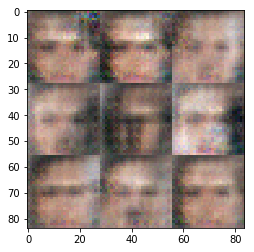

Epoch 1/1... Discriminator Loss: 0.7971... Generator Loss: 0.8608
Epoch 1/1... Discriminator Loss: 0.2803... Generator Loss: 3.3573
Epoch 1/1... Discriminator Loss: 0.7290... Generator Loss: 1.2510
Epoch 1/1... Discriminator Loss: 1.9295... Generator Loss: 0.7275
Epoch 1/1... Discriminator Loss: 1.0055... Generator Loss: 0.9372
Epoch 1/1... Discriminator Loss: 0.9475... Generator Loss: 1.0545
Epoch 1/1... Discriminator Loss: 0.7798... Generator Loss: 1.3853
Epoch 1/1... Discriminator Loss: 3.3761... Generator Loss: 3.2383
Epoch 1/1... Discriminator Loss: 1.5141... Generator Loss: 0.8415
Epoch 1/1... Discriminator Loss: 1.2401... Generator Loss: 0.7900


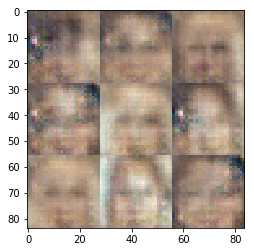

Epoch 1/1... Discriminator Loss: 0.9877... Generator Loss: 1.0603
Epoch 1/1... Discriminator Loss: 1.5136... Generator Loss: 0.5569
Epoch 1/1... Discriminator Loss: 1.6285... Generator Loss: 0.3433
Epoch 1/1... Discriminator Loss: 1.4270... Generator Loss: 0.5539
Epoch 1/1... Discriminator Loss: 1.0448... Generator Loss: 3.0287
Epoch 1/1... Discriminator Loss: 1.2029... Generator Loss: 1.0078
Epoch 1/1... Discriminator Loss: 1.3176... Generator Loss: 0.8909
Epoch 1/1... Discriminator Loss: 0.7055... Generator Loss: 1.4018
Epoch 1/1... Discriminator Loss: 1.3296... Generator Loss: 0.7022
Epoch 1/1... Discriminator Loss: 1.2520... Generator Loss: 0.7452


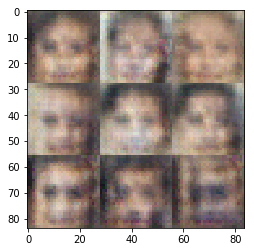

Epoch 1/1... Discriminator Loss: 1.9523... Generator Loss: 1.6501
Epoch 1/1... Discriminator Loss: 1.0921... Generator Loss: 0.9159
Epoch 1/1... Discriminator Loss: 0.9877... Generator Loss: 1.0972
Epoch 1/1... Discriminator Loss: 1.1947... Generator Loss: 1.0221
Epoch 1/1... Discriminator Loss: 1.0710... Generator Loss: 0.7983
Epoch 1/1... Discriminator Loss: 0.5383... Generator Loss: 2.3611
Epoch 1/1... Discriminator Loss: 1.1388... Generator Loss: 0.7985
Epoch 1/1... Discriminator Loss: 1.3746... Generator Loss: 0.7431
Epoch 1/1... Discriminator Loss: 1.3681... Generator Loss: 0.9236
Epoch 1/1... Discriminator Loss: 1.0830... Generator Loss: 0.9156


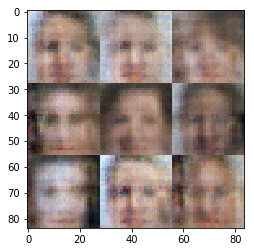

Epoch 1/1... Discriminator Loss: 1.1586... Generator Loss: 0.8078
Epoch 1/1... Discriminator Loss: 1.2643... Generator Loss: 0.6844
Epoch 1/1... Discriminator Loss: 1.0674... Generator Loss: 0.8264
Epoch 1/1... Discriminator Loss: 1.3851... Generator Loss: 0.7427
Epoch 1/1... Discriminator Loss: 1.1784... Generator Loss: 0.9540
Epoch 1/1... Discriminator Loss: 1.2432... Generator Loss: 0.7838
Epoch 1/1... Discriminator Loss: 1.2751... Generator Loss: 0.7345
Epoch 1/1... Discriminator Loss: 1.2705... Generator Loss: 1.0262
Epoch 1/1... Discriminator Loss: 0.4954... Generator Loss: 1.3424
Epoch 1/1... Discriminator Loss: 1.0811... Generator Loss: 0.7899


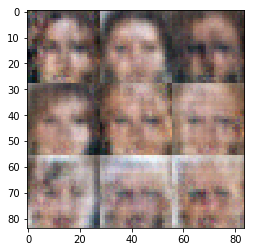

Epoch 1/1... Discriminator Loss: 0.9779... Generator Loss: 1.0650
Epoch 1/1... Discriminator Loss: 1.4302... Generator Loss: 1.8666
Epoch 1/1... Discriminator Loss: 1.2552... Generator Loss: 0.7990
Epoch 1/1... Discriminator Loss: 1.2171... Generator Loss: 0.7153
Epoch 1/1... Discriminator Loss: 1.1629... Generator Loss: 1.0168
Epoch 1/1... Discriminator Loss: 1.1748... Generator Loss: 0.7477
Epoch 1/1... Discriminator Loss: 1.0965... Generator Loss: 0.7639
Epoch 1/1... Discriminator Loss: 0.7502... Generator Loss: 1.1513
Epoch 1/1... Discriminator Loss: 0.7214... Generator Loss: 1.7501
Epoch 1/1... Discriminator Loss: 0.9195... Generator Loss: 0.9984


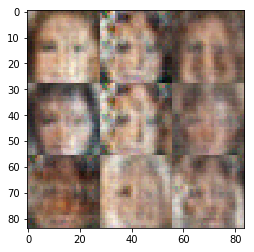

Epoch 1/1... Discriminator Loss: 1.4017... Generator Loss: 0.5245
Epoch 1/1... Discriminator Loss: 1.4825... Generator Loss: 0.4159
Epoch 1/1... Discriminator Loss: 0.4545... Generator Loss: 2.7913
Epoch 1/1... Discriminator Loss: 1.3500... Generator Loss: 1.8358
Epoch 1/1... Discriminator Loss: 1.6560... Generator Loss: 0.6404
Epoch 1/1... Discriminator Loss: 1.2611... Generator Loss: 0.5971
Epoch 1/1... Discriminator Loss: 1.3239... Generator Loss: 1.5343
Epoch 1/1... Discriminator Loss: 1.2279... Generator Loss: 1.4664
Epoch 1/1... Discriminator Loss: 1.1783... Generator Loss: 0.6252
Epoch 1/1... Discriminator Loss: 1.2491... Generator Loss: 0.8117


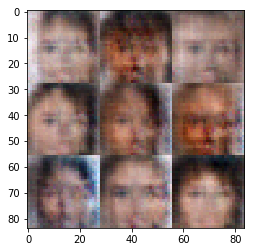

Epoch 1/1... Discriminator Loss: 2.2343... Generator Loss: 2.2517
Epoch 1/1... Discriminator Loss: 1.2806... Generator Loss: 0.6949
Epoch 1/1... Discriminator Loss: 1.1576... Generator Loss: 0.8530
Epoch 1/1... Discriminator Loss: 1.2924... Generator Loss: 0.9053
Epoch 1/1... Discriminator Loss: 1.1691... Generator Loss: 0.8515
Epoch 1/1... Discriminator Loss: 0.8844... Generator Loss: 1.3411
Epoch 1/1... Discriminator Loss: 1.1700... Generator Loss: 1.1812
Epoch 1/1... Discriminator Loss: 1.0587... Generator Loss: 0.8066
Epoch 1/1... Discriminator Loss: 0.9021... Generator Loss: 0.8547
Epoch 1/1... Discriminator Loss: 1.0484... Generator Loss: 0.7772


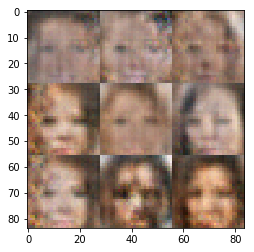

Epoch 1/1... Discriminator Loss: 1.1724... Generator Loss: 0.7179
Epoch 1/1... Discriminator Loss: 1.1933... Generator Loss: 0.6376
Epoch 1/1... Discriminator Loss: 0.9712... Generator Loss: 0.7441
Epoch 1/1... Discriminator Loss: 0.8977... Generator Loss: 1.2710
Epoch 1/1... Discriminator Loss: 3.7679... Generator Loss: 0.0320
Epoch 1/1... Discriminator Loss: 1.2296... Generator Loss: 0.8793
Epoch 1/1... Discriminator Loss: 1.1619... Generator Loss: 0.7586
Epoch 1/1... Discriminator Loss: 1.2099... Generator Loss: 1.0895
Epoch 1/1... Discriminator Loss: 1.0986... Generator Loss: 0.6723
Epoch 1/1... Discriminator Loss: 0.6828... Generator Loss: 1.5785


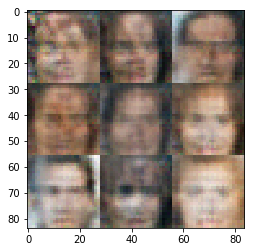

Epoch 1/1... Discriminator Loss: 1.3951... Generator Loss: 0.6404
Epoch 1/1... Discriminator Loss: 1.0662... Generator Loss: 1.0044
Epoch 1/1... Discriminator Loss: 1.1535... Generator Loss: 0.6857
Epoch 1/1... Discriminator Loss: 1.4821... Generator Loss: 1.5564
Epoch 1/1... Discriminator Loss: 1.0565... Generator Loss: 0.9031
Epoch 1/1... Discriminator Loss: 1.2356... Generator Loss: 0.7929
Epoch 1/1... Discriminator Loss: 1.1003... Generator Loss: 0.6088
Epoch 1/1... Discriminator Loss: 1.4004... Generator Loss: 0.4449
Epoch 1/1... Discriminator Loss: 0.8296... Generator Loss: 1.1295
Epoch 1/1... Discriminator Loss: 1.3810... Generator Loss: 1.9813


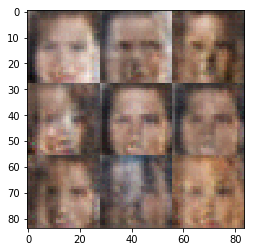

Epoch 1/1... Discriminator Loss: 0.7356... Generator Loss: 1.4095
Epoch 1/1... Discriminator Loss: 1.4133... Generator Loss: 0.4304
Epoch 1/1... Discriminator Loss: 0.5049... Generator Loss: 1.5960
Epoch 1/1... Discriminator Loss: 1.0864... Generator Loss: 0.8329
Epoch 1/1... Discriminator Loss: 2.1349... Generator Loss: 0.1952
Epoch 1/1... Discriminator Loss: 1.1097... Generator Loss: 0.7137
Epoch 1/1... Discriminator Loss: 1.2947... Generator Loss: 0.7047
Epoch 1/1... Discriminator Loss: 0.8117... Generator Loss: 2.6479
Epoch 1/1... Discriminator Loss: 0.8528... Generator Loss: 0.9245
Epoch 1/1... Discriminator Loss: 0.8375... Generator Loss: 1.4141


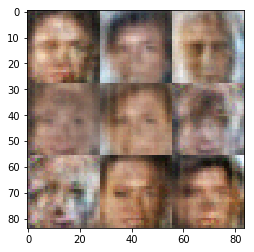

Epoch 1/1... Discriminator Loss: 0.9751... Generator Loss: 0.8227
Epoch 1/1... Discriminator Loss: 1.0608... Generator Loss: 0.7765
Epoch 1/1... Discriminator Loss: 1.5229... Generator Loss: 2.2778
Epoch 1/1... Discriminator Loss: 1.1876... Generator Loss: 0.8716
Epoch 1/1... Discriminator Loss: 1.1969... Generator Loss: 0.5942
Epoch 1/1... Discriminator Loss: 1.0900... Generator Loss: 0.6343
Epoch 1/1... Discriminator Loss: 1.0225... Generator Loss: 1.4263
Epoch 1/1... Discriminator Loss: 0.9065... Generator Loss: 0.8895
Epoch 1/1... Discriminator Loss: 0.9826... Generator Loss: 1.6796
Epoch 1/1... Discriminator Loss: 1.5269... Generator Loss: 0.3429


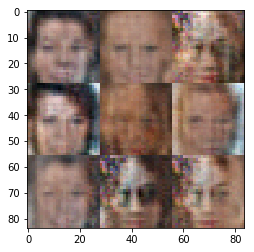

Epoch 1/1... Discriminator Loss: 0.9287... Generator Loss: 1.2222
Epoch 1/1... Discriminator Loss: 1.1624... Generator Loss: 0.7442
Epoch 1/1... Discriminator Loss: 1.0704... Generator Loss: 0.9000
Epoch 1/1... Discriminator Loss: 1.3115... Generator Loss: 0.4875
Epoch 1/1... Discriminator Loss: 0.8637... Generator Loss: 1.4154
Epoch 1/1... Discriminator Loss: 1.7971... Generator Loss: 0.2382
Epoch 1/1... Discriminator Loss: 1.2509... Generator Loss: 0.6753
Epoch 1/1... Discriminator Loss: 1.1665... Generator Loss: 0.9759
Epoch 1/1... Discriminator Loss: 1.3817... Generator Loss: 0.5575
Epoch 1/1... Discriminator Loss: 0.8897... Generator Loss: 1.1181


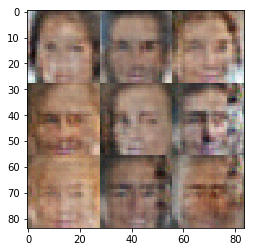

Epoch 1/1... Discriminator Loss: 1.0233... Generator Loss: 0.7621
Epoch 1/1... Discriminator Loss: 1.4180... Generator Loss: 1.2731
Epoch 1/1... Discriminator Loss: 1.1266... Generator Loss: 1.2591
Epoch 1/1... Discriminator Loss: 0.9342... Generator Loss: 1.9306
Epoch 1/1... Discriminator Loss: 1.5442... Generator Loss: 0.4919
Epoch 1/1... Discriminator Loss: 1.2224... Generator Loss: 0.6753
Epoch 1/1... Discriminator Loss: 1.3044... Generator Loss: 0.6430
Epoch 1/1... Discriminator Loss: 1.2515... Generator Loss: 0.6593
Epoch 1/1... Discriminator Loss: 1.1931... Generator Loss: 0.8683
Epoch 1/1... Discriminator Loss: 1.1444... Generator Loss: 1.2784


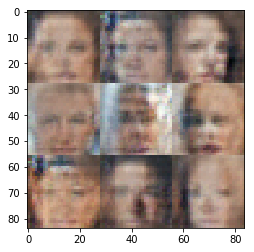

Epoch 1/1... Discriminator Loss: 1.0404... Generator Loss: 1.3307
Epoch 1/1... Discriminator Loss: 0.8405... Generator Loss: 1.7679
Epoch 1/1... Discriminator Loss: 1.1003... Generator Loss: 0.8718
Epoch 1/1... Discriminator Loss: 1.0963... Generator Loss: 1.0109
Epoch 1/1... Discriminator Loss: 1.2290... Generator Loss: 0.9012
Epoch 1/1... Discriminator Loss: 1.1256... Generator Loss: 1.1561
Epoch 1/1... Discriminator Loss: 1.6057... Generator Loss: 0.3482
Epoch 1/1... Discriminator Loss: 1.0371... Generator Loss: 0.8566
Epoch 1/1... Discriminator Loss: 0.7047... Generator Loss: 1.4298
Epoch 1/1... Discriminator Loss: 1.2612... Generator Loss: 0.5453


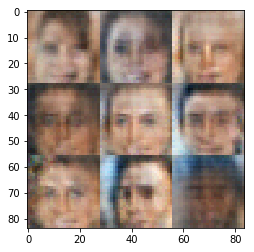

Epoch 1/1... Discriminator Loss: 0.9816... Generator Loss: 0.6735
Epoch 1/1... Discriminator Loss: 1.4355... Generator Loss: 0.8365
Epoch 1/1... Discriminator Loss: 1.3688... Generator Loss: 0.7578
Epoch 1/1... Discriminator Loss: 1.2513... Generator Loss: 0.7041
Epoch 1/1... Discriminator Loss: 1.2902... Generator Loss: 0.8668
Epoch 1/1... Discriminator Loss: 1.4471... Generator Loss: 0.4595
Epoch 1/1... Discriminator Loss: 1.1916... Generator Loss: 0.8964
Epoch 1/1... Discriminator Loss: 1.1633... Generator Loss: 0.7174
Epoch 1/1... Discriminator Loss: 1.4013... Generator Loss: 0.5705
Epoch 1/1... Discriminator Loss: 1.0704... Generator Loss: 0.6505


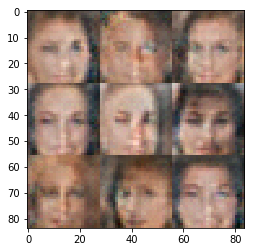

Epoch 1/1... Discriminator Loss: 0.8990... Generator Loss: 0.9901
Epoch 1/1... Discriminator Loss: 1.4478... Generator Loss: 0.6995
Epoch 1/1... Discriminator Loss: 1.4349... Generator Loss: 0.8485
Epoch 1/1... Discriminator Loss: 1.2771... Generator Loss: 1.9432
Epoch 1/1... Discriminator Loss: 1.1013... Generator Loss: 1.0109
Epoch 1/1... Discriminator Loss: 0.8339... Generator Loss: 1.3108
Epoch 1/1... Discriminator Loss: 1.0349... Generator Loss: 1.2112
Epoch 1/1... Discriminator Loss: 1.3231... Generator Loss: 0.5095
Epoch 1/1... Discriminator Loss: 1.0258... Generator Loss: 0.7669
Epoch 1/1... Discriminator Loss: 1.0824... Generator Loss: 0.8466


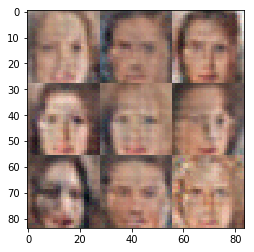

Epoch 1/1... Discriminator Loss: 1.0016... Generator Loss: 1.0557
Epoch 1/1... Discriminator Loss: 1.1496... Generator Loss: 1.1444
Epoch 1/1... Discriminator Loss: 1.2609... Generator Loss: 0.9634
Epoch 1/1... Discriminator Loss: 1.0301... Generator Loss: 0.9586
Epoch 1/1... Discriminator Loss: 1.2634... Generator Loss: 0.6026
Epoch 1/1... Discriminator Loss: 0.7185... Generator Loss: 1.7765
Epoch 1/1... Discriminator Loss: 1.1411... Generator Loss: 0.8871
Epoch 1/1... Discriminator Loss: 1.1690... Generator Loss: 0.8638
Epoch 1/1... Discriminator Loss: 1.2498... Generator Loss: 0.8662
Epoch 1/1... Discriminator Loss: 1.1574... Generator Loss: 0.7357


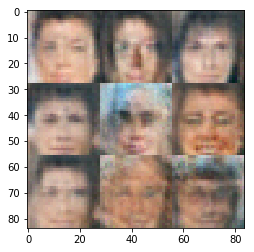

Epoch 1/1... Discriminator Loss: 2.1401... Generator Loss: 0.1725
Epoch 1/1... Discriminator Loss: 1.4076... Generator Loss: 0.5737
Epoch 1/1... Discriminator Loss: 1.2760... Generator Loss: 0.6995
Epoch 1/1... Discriminator Loss: 1.1053... Generator Loss: 1.1294
Epoch 1/1... Discriminator Loss: 1.3764... Generator Loss: 0.6466
Epoch 1/1... Discriminator Loss: 1.0805... Generator Loss: 1.0892
Epoch 1/1... Discriminator Loss: 1.1833... Generator Loss: 0.8023
Epoch 1/1... Discriminator Loss: 1.1307... Generator Loss: 1.0070
Epoch 1/1... Discriminator Loss: 1.0090... Generator Loss: 0.9218
Epoch 1/1... Discriminator Loss: 1.4011... Generator Loss: 0.5039


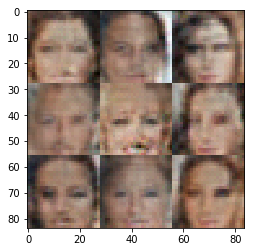

Epoch 1/1... Discriminator Loss: 1.3387... Generator Loss: 0.7692
Epoch 1/1... Discriminator Loss: 1.4787... Generator Loss: 0.4196
Epoch 1/1... Discriminator Loss: 1.1990... Generator Loss: 0.5890
Epoch 1/1... Discriminator Loss: 1.0779... Generator Loss: 0.8167
Epoch 1/1... Discriminator Loss: 1.2156... Generator Loss: 1.0370
Epoch 1/1... Discriminator Loss: 1.4235... Generator Loss: 1.3081
Epoch 1/1... Discriminator Loss: 1.1830... Generator Loss: 0.7728
Epoch 1/1... Discriminator Loss: 1.3130... Generator Loss: 0.6442
Epoch 1/1... Discriminator Loss: 1.6236... Generator Loss: 0.9142
Epoch 1/1... Discriminator Loss: 1.1283... Generator Loss: 0.6704


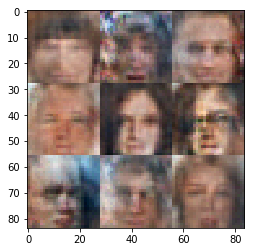

Epoch 1/1... Discriminator Loss: 1.4878... Generator Loss: 0.3841
Epoch 1/1... Discriminator Loss: 1.3774... Generator Loss: 0.8773
Epoch 1/1... Discriminator Loss: 1.7346... Generator Loss: 0.3004
Epoch 1/1... Discriminator Loss: 1.1481... Generator Loss: 0.8533
Epoch 1/1... Discriminator Loss: 0.8677... Generator Loss: 1.6335
Epoch 1/1... Discriminator Loss: 1.8059... Generator Loss: 1.3615
Epoch 1/1... Discriminator Loss: 1.0933... Generator Loss: 1.0730
Epoch 1/1... Discriminator Loss: 1.1372... Generator Loss: 0.7401
Epoch 1/1... Discriminator Loss: 1.1493... Generator Loss: 0.9222
Epoch 1/1... Discriminator Loss: 1.2533... Generator Loss: 0.7892


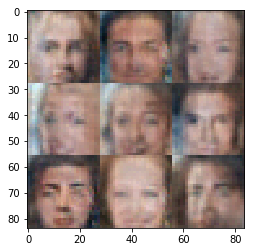

Epoch 1/1... Discriminator Loss: 1.1958... Generator Loss: 0.7605
Epoch 1/1... Discriminator Loss: 1.1041... Generator Loss: 0.9241
Epoch 1/1... Discriminator Loss: 1.0950... Generator Loss: 0.8340
Epoch 1/1... Discriminator Loss: 1.0510... Generator Loss: 0.8715
Epoch 1/1... Discriminator Loss: 0.8939... Generator Loss: 0.9390
Epoch 1/1... Discriminator Loss: 1.2780... Generator Loss: 1.0791
Epoch 1/1... Discriminator Loss: 1.2656... Generator Loss: 0.7655
Epoch 1/1... Discriminator Loss: 0.9880... Generator Loss: 0.8721
Epoch 1/1... Discriminator Loss: 1.1468... Generator Loss: 0.7335
Epoch 1/1... Discriminator Loss: 0.9447... Generator Loss: 1.1884


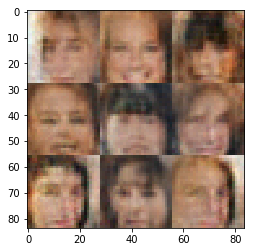

Epoch 1/1... Discriminator Loss: 1.7595... Generator Loss: 0.2936
Epoch 1/1... Discriminator Loss: 1.0532... Generator Loss: 1.3030
Epoch 1/1... Discriminator Loss: 1.1041... Generator Loss: 0.9652
Epoch 1/1... Discriminator Loss: 1.2592... Generator Loss: 0.5855
Epoch 1/1... Discriminator Loss: 1.1707... Generator Loss: 0.7413
Epoch 1/1... Discriminator Loss: 0.9995... Generator Loss: 1.1119
Epoch 1/1... Discriminator Loss: 1.4057... Generator Loss: 0.5369
Epoch 1/1... Discriminator Loss: 1.2956... Generator Loss: 0.8454
Epoch 1/1... Discriminator Loss: 1.5186... Generator Loss: 0.4132
Epoch 1/1... Discriminator Loss: 1.2744... Generator Loss: 0.9417


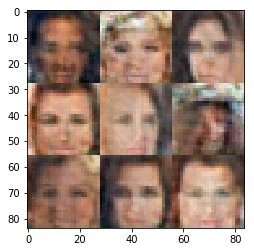

Epoch 1/1... Discriminator Loss: 1.3154... Generator Loss: 0.5151
Epoch 1/1... Discriminator Loss: 1.0922... Generator Loss: 0.7048
Epoch 1/1... Discriminator Loss: 1.1547... Generator Loss: 0.9962
Epoch 1/1... Discriminator Loss: 1.0576... Generator Loss: 1.0538
Epoch 1/1... Discriminator Loss: 1.3745... Generator Loss: 0.5652
Epoch 1/1... Discriminator Loss: 1.4788... Generator Loss: 0.5184
Epoch 1/1... Discriminator Loss: 1.3957... Generator Loss: 0.6199
Epoch 1/1... Discriminator Loss: 1.3061... Generator Loss: 0.6642
Epoch 1/1... Discriminator Loss: 1.0482... Generator Loss: 0.9427
Epoch 1/1... Discriminator Loss: 1.2132... Generator Loss: 0.7667


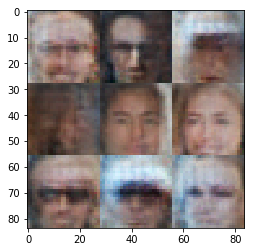

Epoch 1/1... Discriminator Loss: 1.2609... Generator Loss: 0.8234
Epoch 1/1... Discriminator Loss: 1.3053... Generator Loss: 0.9296
Epoch 1/1... Discriminator Loss: 1.0990... Generator Loss: 0.9437
Epoch 1/1... Discriminator Loss: 1.4988... Generator Loss: 0.4743
Epoch 1/1... Discriminator Loss: 1.5541... Generator Loss: 0.3473
Epoch 1/1... Discriminator Loss: 2.0512... Generator Loss: 1.9413


In [14]:
batch_size = 64
z_dim = 100
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.